# Overwatch Hero Survey (September 2019)

In [124]:
import pandas as pd
import seaborn as sb
import ipywidgets as widgets
import numpy as np
from ipywidgets import interact, interact_manual
from matplotlib import pyplot as plt

# load flat csv files -- the survey results are a little clunky
hero_names_df = pd.read_csv("../data/overwatch_heroes.csv").loc[:,["Hero_name"]]
basic_info_df = pd.read_csv("../data/table_basic_info.csv")
hero_ratings_df = pd.read_csv("../data/table_hero_ratings.csv")

# join on Response_id such that we can more easily query the result set
joined_df = basic_info_df.set_index('Response_id').join(
    hero_ratings_df.set_index('Response_id'), 
    lsuffix='caller', 
    rsuffix='_other')

RATING_MIN=1
RATING_MAX=5
CHART_BAR_FIGSIZE=(6, 12)
CHART_HIST_FIGSIZE=(6, 6)

In [125]:
# helper functions for graphs
def set_graph_format_x_axis(ax):
    ax.set(xlim=(RATING_MIN, RATING_MAX))
    plt.xticks(np.arange(RATING_MIN, RATING_MAX + 1, 1))

In [126]:
def hero_vs_fun_factor(df):
    return (df.query('Response_type == "Playing_vs"')
            .groupby('Hero', as_index=False)
            .mean()
            .sort_values(by='Value'))

In [138]:
def draw_vs_fun_factor_graph(df):
    f, ax = plt.subplots(figsize=CHART_BAR_FIGSIZE)                
    ax = sb.barplot(x="Value", y="Hero", data=df)
    set_graph_format_x_axis(ax)
    ax.set_title("Which heroes are fun to play against?")
    ax.set(xlabel="Fun factor (higher is more enjoyable)")

## Q: Which heroes are fun to play against?

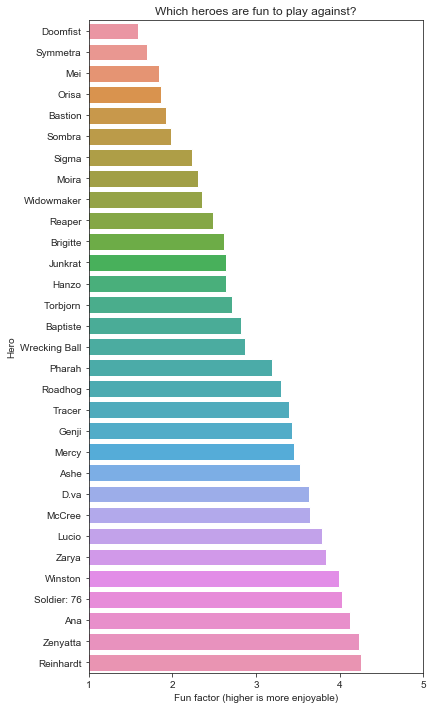

In [137]:
draw_vs_fun_factor_graph(hero_vs_fun_factor(joined_df))

In [129]:
def hero_balance(df):
    return (joined_df.query('Response_type == "Balance"')
            .groupby('Hero', as_index=False)
            .mean()
            .sort_values(by='Value'))

In [130]:
def draw_hero_balance_graph(df):
    f, ax = plt.subplots(figsize=CHART_BAR_FIGSIZE)
    ax = sb.barplot(x="Value", y="Hero", data=df)
    set_graph_format_x_axis(ax)
    
    # plot ideal balance line
    balance_line_x = CHART_BAR_FIGSIZE[0] * 0.5
    plt.axvline(balance_line_x, 0.0, 1.0).set_linestyle('dashed')
    
    ax.set_title("Which heroes are perceived to be balanced?")
    ax.set(xlabel="Balance rating -- 3 is considered to be well-balanced")

## Q: Which heroes are perceived to be the most over-tuned?

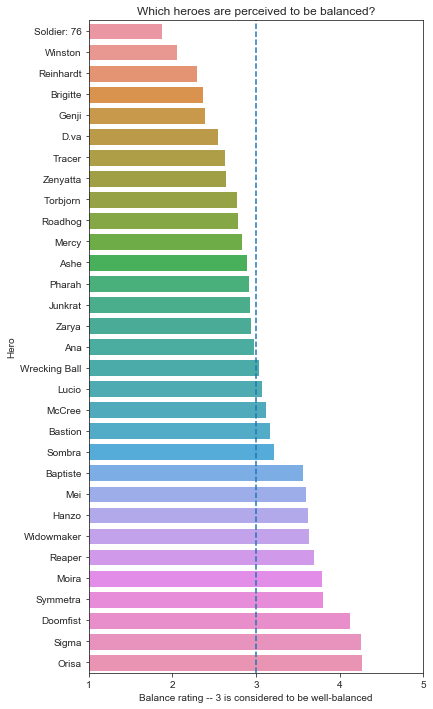

In [131]:
draw_hero_balance_graph(hero_balance(joined_df))

### Let's break down balance by hero & see the range of votes

In [132]:
@interact
def hero_balance_histograms(column=list(sorted(hero_names_df['Hero_name']))):
    hero_playing_vs_df = (joined_df.query('Response_type == "Playing_vs"')
                          .groupby('Hero'))['Value']

    f, ax = plt.subplots(figsize=CHART_HIST_FIGSIZE)
    sb.set_style("ticks")
    dp = sb.distplot(hero_playing_vs_df.get_group(column), bins=5, kde=False)
    dp.set(xlabel=f'Playing vs {column}', ylabel='Counts')    
    plt.show()        

interactive(children=(Dropdown(description='column', options=('Ana', 'Ashe', 'Baptiste', 'Bastion', 'Brigitte'…

## Q: Which heroes are unpopular relative to their perceived balance level? 

In [133]:
def hero_fun_vs_balance(df):
    # Q: which heroes are unpopular relative to their perceived balance level? 
    # (i.e. people dislike playing against them even if they're not considered OP)
    playing_vs_df = (df.query('Response_type == "Playing_vs"')
     .groupby('Hero')
     .mean())    

    balance_df = (df.query('Response_type == "Balance"')
     .groupby('Hero') 
     .mean()
     .query('Value > 2.25 & Value < 3.75'))

    fun_balance_df = (playing_vs_df.join(
        balance_df,    
        lsuffix='_fun', 
        rsuffix='_balance')
      .query('Value_balance.notnull()')) # filter out the invalid joined data; should do this first though

    # this is pretty arbitrary, but gives us a decent idea of 'fun/unfun' vs balance
    fun_balance_ratio_df = fun_balance_df["Value_fun"] - fun_balance_df["Value_balance"]
    fun_balance_ratio_df.sort_values(inplace=True)
    
    return fun_balance_ratio_df

    # note: this would be better served as a chart (maybe divide by role) that shows 
    # the perceived fun value overlayed on the balance value.

In [134]:
print(hero_fun_vs_balance(joined_df))

Hero
Mei             -1.760870
Widowmaker      -1.287625
Bastion         -1.239130
Sombra          -1.232441
Reaper          -1.204849
Hanzo           -0.982441
Baptiste        -0.749164
Junkrat         -0.294314
Wrecking Ball   -0.166388
Torbjorn        -0.049331
Brigitte         0.255853
Pharah           0.278428
Roadhog          0.520903
McCree           0.529264
Mercy            0.619565
Ashe             0.630435
Lucio            0.722408
Tracer           0.765886
Zarya            0.897993
Genji            1.044314
D.va             1.079431
Ana              1.145485
Zenyatta         1.593645
Reinhardt        1.957358
dtype: float64


## Q: When playing as our main, which heroes are least fun to play against?

In [143]:
def hero_fun_vs_balance_by_main(df, hero_names):    
    @interact
    def hero_fun_vs_balance_by_main_interact(column=hero_names):
        hero_name = column
        hero_playing_as_df = (df.query(
            f'Hero_favourite == "{hero_name}" & Response_type == "Playing_vs"'))

        # for hero x, we have results for playing against all heroes. 
        # spin through every result in this set and query for the top 3 most-hated
        least_fun_group = (hero_playing_as_df
                           .query(f'Response_type == "Playing_vs"')
                           .groupby("Hero", as_index=False))

        least_fun_mean = least_fun_group.mean()
        
        # Initialize the matplotlib figure
        f, ax = plt.subplots(figsize=CHART_BAR_FIGSIZE)
        ax = sb.barplot(x="Value", y="Hero", data=least_fun_mean)
        #set_graph_format_x_axis(ax)
        ax.set_title(f"Respondents' main: {hero_name}")
        ax.set(xlabel="Fun factor (higher is more enjoyable)", ylabel="Playing against hero")
        
hero_fun_vs_balance_by_main(joined_df, list(sorted(hero_names_df['Hero_name'])))


interactive(children=(Dropdown(description='column', options=('Ana', 'Ashe', 'Baptiste', 'Bastion', 'Brigitte'…